# **Proyecto Final - Introducción a Machine Learning**

##***Detección de Retinopatías Diabéticas con Machine Learning***

### **Integrantes:**


*   Ayabar Escobar Edithson Ricardo
*   Luque Mamani Magno Ricardo
*   Quezada Marceliano Gian Carlos



##**Analizando características de las imágenes:**

In [ ]:
!pip install opendatasets
import opendatasets as od # para poder conectarnos con la API de kaggle

In [ ]:
link_conjunto_de_datos = 'https://www.kaggle.com/competitions/upch-intro-ml'
od.download(link_conjunto_de_datos) # descargamos el conjunto de datos

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: liondbdb
Your Kaggle Key: ··········


100%|██████████| 2.03G/2.03G [00:18<00:00, 118MB/s]



Extracting archive ./upch-intro-ml/upch-intro-ml.zip to ./upch-intro-ml


In [ ]:
# Importamos las librerías
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
import os
import sys
import tqdm
import plotly.graph_objects as go
from tensorflow.keras import models
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50
from contextlib import contextmanager

In [ ]:
os.chdir('upch-intro-ml')
os.listdir()

['train.csv', 'test', 'sample.csv', 'train']

In [ ]:
# Leemos los Data Frames
df_train = pd.read_csv("/content/upch-intro-ml/train.csv")
df_samples = pd.read_csv("/content/upch-intro-ml/sample.csv")

# Ahora ubicaremos las rutas donde se encuentran las imágenes para el entrenamiento de nuestro modelo
carpeta_imagenes_train = '/content/upch-intro-ml/train/train'

# Ahora haremos lo mismo con la carpeta donde se encuentran las imágenes de prueba
carpeta_imagenes_test = '/content/upch-intro-ml/test/test'

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24588 entries, 0 to 24587
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   ID        24588 non-null  object
 1   location  24588 non-null  object
 2   level     24588 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 576.4+ KB


In [ ]:
df_train['level'].value_counts().index

Index([0, 1], dtype='int64', name='level')

In [ ]:
df_train

,ID,location,level
0,d3d9446802a44259755d38e6d163e820,left,0
1,d3d9446802a44259755d38e6d163e820,right,0
2,c51ce410c124a10e0db5e4b97fc2af39,left,0
3,c51ce410c124a10e0db5e4b97fc2af39,right,0
4,9bf31c7ff062936a96d3c8bd1f8f2ff3,left,1
...,...,...,...
24583,7dc5ece165388748790d8170245197ed,right,0
24584,e3c216d521607da146fa23d65cfcc6b6,left,0
24585,e3c216d521607da146fa23d65cfcc6b6,right,0
24586,54d9ee4df2caa006b994d148f23a9b10,left,0


In [ ]:
# Mostramos un gráfico de barras interactivo

fig = go.Figure([go.Bar(x = df_train['level'].value_counts().index, y = df_train['level'].value_counts())])
fig.update_traces(marker_color = 'rgb(0,200,0)', marker_line_color = 'rgb(0,255,0)',
                  marker_line_width = 7, opacity = 0.6)
fig.show()

In [ ]:
df_train.ID

0        d3d9446802a44259755d38e6d163e820
1        d3d9446802a44259755d38e6d163e820
2        c51ce410c124a10e0db5e4b97fc2af39
3        c51ce410c124a10e0db5e4b97fc2af39
4        9bf31c7ff062936a96d3c8bd1f8f2ff3
                       ...               
24583    7dc5ece165388748790d8170245197ed
24584    e3c216d521607da146fa23d65cfcc6b6
24585    e3c216d521607da146fa23d65cfcc6b6
24586    54d9ee4df2caa006b994d148f23a9b10
24587    54d9ee4df2caa006b994d148f23a9b10
Name: ID, Length: 24588, dtype: object

In [ ]:
df_samples.ID

0         c74d97b01eae257e44aa9d5bade97baf_left
1        c74d97b01eae257e44aa9d5bade97baf_right
2         70efdf2ec9b086079795c442636b55fb_left
3        70efdf2ec9b086079795c442636b55fb_right
4         1f0e3dad99908345f7439f8ffabdffc4_left
                          ...                  
10533    e261790d3a4cb0c69c17d7c183830289_right
10534     d21137447f7fdc47f7e6677ae35522a7_left
10535    d21137447f7fdc47f7e6677ae35522a7_right
10536     ec2951e5afb60d72a4a3e0be6d3e9c0a_left
10537    ec2951e5afb60d72a4a3e0be6d3e9c0a_right
Name: ID, Length: 10538, dtype: object

## **Extrayendo características de todas las imágenes de entrenamiento en base al Data Frame:**

In [ ]:
# Función que permite obtener información de acuerdo al Data Frame de entrenamiento
# Listamos las imágenes en base al orden en el Data Frame

def nombreImagenTrain(df):
  almacenamiento_rutas = []
  almacenamiento_c_s = []
  for i, fila in df.iterrows():
    id = fila['ID']
    ubicacion = fila['location']
    estado = fila['level']
    archivo_imagen = os.path.join(carpeta_imagenes_train, f'{id}_{ubicacion}.jpg')

    almacenamiento_rutas.append(archivo_imagen)
    almacenamiento_c_s.append(estado)

  return almacenamiento_rutas, almacenamiento_c_s

In [ ]:
# Función que permite obtener información de acuerdo al Data Frame de muestra

def nombreImagenSamples(df):
  almacenamiento_rutas = []
  almacenamiento_c_s = []
  for i, fila in df.iterrows():
    id = fila['ID']
    archivo_imagen = os.path.join(carpeta_imagenes_test, f'{id}.jpg')

    almacenamiento_rutas.append(archivo_imagen)

  return almacenamiento_rutas

In [ ]:
archivos_train, etiquetas = nombreImagenTrain(df_train)

In [ ]:
archivos_test = nombreImagenSamples(df_samples)

In [ ]:
archivos_train[:10]

['/content/upch-intro-ml/train/train/d3d9446802a44259755d38e6d163e820_left.jpg',
 '/content/upch-intro-ml/train/train/d3d9446802a44259755d38e6d163e820_right.jpg',
 '/content/upch-intro-ml/train/train/c51ce410c124a10e0db5e4b97fc2af39_left.jpg',
 '/content/upch-intro-ml/train/train/c51ce410c124a10e0db5e4b97fc2af39_right.jpg',
 '/content/upch-intro-ml/train/train/9bf31c7ff062936a96d3c8bd1f8f2ff3_left.jpg',
 '/content/upch-intro-ml/train/train/9bf31c7ff062936a96d3c8bd1f8f2ff3_right.jpg',
 '/content/upch-intro-ml/train/train/98f13708210194c475687be6106a3b84_left.jpg',
 '/content/upch-intro-ml/train/train/98f13708210194c475687be6106a3b84_right.jpg',
 '/content/upch-intro-ml/train/train/b6d767d2f8ed5d21a44b0e5886680cb9_left.jpg',
 '/content/upch-intro-ml/train/train/b6d767d2f8ed5d21a44b0e5886680cb9_right.jpg']

In [ ]:
archivos_test[:10]

['/content/upch-intro-ml/test/test/c74d97b01eae257e44aa9d5bade97baf_left.jpg',
 '/content/upch-intro-ml/test/test/c74d97b01eae257e44aa9d5bade97baf_right.jpg',
 '/content/upch-intro-ml/test/test/70efdf2ec9b086079795c442636b55fb_left.jpg',
 '/content/upch-intro-ml/test/test/70efdf2ec9b086079795c442636b55fb_right.jpg',
 '/content/upch-intro-ml/test/test/1f0e3dad99908345f7439f8ffabdffc4_left.jpg',
 '/content/upch-intro-ml/test/test/1f0e3dad99908345f7439f8ffabdffc4_right.jpg',
 '/content/upch-intro-ml/test/test/3c59dc048e8850243be8079a5c74d079_left.jpg',
 '/content/upch-intro-ml/test/test/3c59dc048e8850243be8079a5c74d079_right.jpg',
 '/content/upch-intro-ml/test/test/67c6a1e7ce56d3d6fa748ab6d9af3fd7_left.jpg',
 '/content/upch-intro-ml/test/test/67c6a1e7ce56d3d6fa748ab6d9af3fd7_right.jpg']

In [ ]:
ruta_img = cv2.imread(archivos_train[10])

In [ ]:
ruta_img.shape

(533, 800, 3)

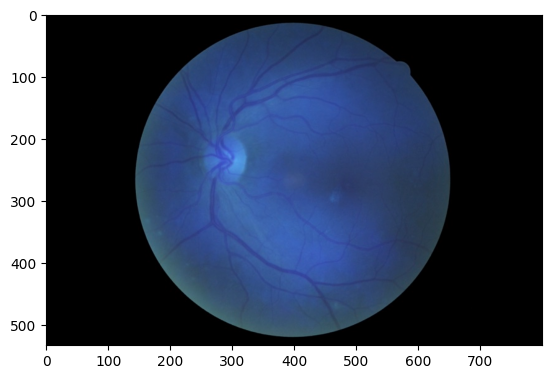

In [ ]:
plt.imshow(ruta_img)

In [ ]:
df_train['ID'] = archivos_train
df_train

,ID,location,level
0,/content/upch-intro-ml/train/train/d3d9446802a...,left,0
1,/content/upch-intro-ml/train/train/d3d9446802a...,right,0
2,/content/upch-intro-ml/train/train/c51ce410c12...,left,0
3,/content/upch-intro-ml/train/train/c51ce410c12...,right,0
4,/content/upch-intro-ml/train/train/9bf31c7ff06...,left,1
...,...,...,...
24583,/content/upch-intro-ml/train/train/7dc5ece1653...,right,0
24584,/content/upch-intro-ml/train/train/e3c216d5216...,left,0
24585,/content/upch-intro-ml/train/train/e3c216d5216...,right,0
24586,/content/upch-intro-ml/train/train/54d9ee4df2c...,left,0


In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24588 entries, 0 to 24587
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   ID        24588 non-null  object
 1   location  24588 non-null  object
 2   level     24588 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 576.4+ KB


In [ ]:
df_samples['ID'] = archivos_test
df_samples

,ID,score
0,/content/upch-intro-ml/test/test/c74d97b01eae2...,0
1,/content/upch-intro-ml/test/test/c74d97b01eae2...,0
2,/content/upch-intro-ml/test/test/70efdf2ec9b08...,0
3,/content/upch-intro-ml/test/test/70efdf2ec9b08...,0
4,/content/upch-intro-ml/test/test/1f0e3dad99908...,0
...,...,...
10533,/content/upch-intro-ml/test/test/e261790d3a4cb...,0
10534,/content/upch-intro-ml/test/test/d21137447f7fd...,0
10535,/content/upch-intro-ml/test/test/d21137447f7fd...,0
10536,/content/upch-intro-ml/test/test/ec2951e5afb60...,0


In [ ]:
df_samples.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10538 entries, 0 to 10537
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      10538 non-null  object
 1   score   10538 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 164.8+ KB


In [ ]:
# Convertimos la conlumna 'level' en el tipo de dato object

df_train['level'] = df_train['level'].astype('str')
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24588 entries, 0 to 24587
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   ID        24588 non-null  object
 1   location  24588 non-null  object
 2   level     24588 non-null  object
dtypes: object(3)
memory usage: 576.4+ KB


In [ ]:
# Creamos el generado de datos
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255.,
                                                          validation_split = 0.2,
                                                          horizontal_flip=True)

In [ ]:
# Preparamos los datos de entrenamiento con el generador de datos
train_generator=datagen.flow_from_dataframe(
dataframe=df_train,
directory= carpeta_imagenes_train,
x_col='ID',
y_col='level',
subset="training",
batch_size=8,
class_mode="binary",
target_size=(512,512))

# Preparamos los datos de validación con el generador de datos
valid_generator=datagen.flow_from_dataframe(
dataframe=df_train,
directory= carpeta_imagenes_train,
x_col='ID',
y_col='level',
subset="validation",
batch_size=8,
class_mode="binary",
target_size=(512,512))

Found 19671 validated image filenames belonging to 2 classes.
Found 4917 validated image filenames belonging to 2 classes.


In [ ]:
basemodel = ResNet50(weights = 'imagenet', include_top = False, input_tensor = Input(shape=(512, 512, 3)), pooling='avg')

94765736/94765736 [==============================] - 0s 0us/step


In [ ]:
basemodel.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 512, 512, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 518, 518, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 256, 256, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 256, 256, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                       

In [ ]:
# Adecuamos el modelo con las últimas capas
headmodel = basemodel.output
headmodel = tf.keras.layers.Flatten(name= 'flatten')(headmodel)
headmodel = tf.keras.layers.Dropout(0.2)(headmodel)
headmodel = tf.keras.layers.Dense(256, activation = "relu")(headmodel)
headmodel = tf.keras.layers.Dense(1, activation = 'sigmoid')(headmodel)

model = Model(inputs = basemodel.input, outputs = headmodel)

In [ ]:
for layer in model.layers:
    layer.trainable = False

for i in range(-5, 0):
    model.layers[i].trainable = True

In [ ]:
model.compile(optimizer=Adam(learning_rate=1e-3), loss = 'binary_crossentropy', metrics= ["accuracy"])

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 512, 512, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 518, 518, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 256, 256, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 256, 256, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                          

In [ ]:
history = model.fit(train_generator,
                    epochs=2,
                    validation_data= valid_generator,
                    verbose=1).history

Epoch 1/2
2459/2459 [==============================] - 432s 172ms/step - loss: 0.5993 - accuracy: 0.7275 - val_loss: 0.5862 - val_accuracy: 0.7291
Epoch 2/2
2459/2459 [==============================] - 417s 169ms/step - loss: 0.5806 - accuracy: 0.7357 - val_loss: 0.5842 - val_accuracy: 0.7291


In [ ]:
for layer in model.layers:   # Iteramos las capas del modelo
    layer.trainable = True   # Activamos las capas para el entrenamiento

# Definimos los callbacks
es = EarlyStopping(monitor='val_loss', mode='min', patience=5, restore_best_weights=True, verbose=1)
rlrop = ReduceLROnPlateau(monitor='val_loss', mode='min', patience=3, factor=0.5, min_lr=1e-6, verbose=1)

callback_list = [es, rlrop] # Lo adecuamos en una lista

In [ ]:
# Compilamos el modelo
model.compile(optimizer=Adam(learning_rate=1e-4), # Especificamos la tasa de aprendizaje utilizando el optimizador Adam
              loss="binary_crossentropy", # Definimos la función de perdida para el problema de clasificación binaria
              metrics=["accuracy"])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 512, 512, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 518, 518, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 256, 256, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 256, 256, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                          

In [ ]:
history_mejorado = model.fit(train_generator,
                                epochs=5,
                                validation_data=valid_generator,
                                callbacks=callback_list,
                                verbose=1).history

Epoch 1/5
2459/2459 [==============================] - 1146s 466ms/step - loss: 0.4425 - accuracy: 0.8162 - val_loss: 0.4574 - val_accuracy: 0.8037 - lr: 1.0000e-04
Epoch 2/5
2459/2459 [==============================] - 1139s 463ms/step - loss: 0.3894 - accuracy: 0.8434 - val_loss: 0.4233 - val_accuracy: 0.8320 - lr: 1.0000e-04
Epoch 3/5
2459/2459 [==============================] - 1137s 462ms/step - loss: 0.3647 - accuracy: 0.8570 - val_loss: 0.3783 - val_accuracy: 0.8519 - lr: 1.0000e-04
Epoch 4/5
2459/2459 [==============================] - 1199s 487ms/step - loss: 0.3372 - accuracy: 0.8704 - val_loss: 0.3816 - val_accuracy: 0.8495 - lr: 1.0000e-04
Epoch 5/5
2459/2459 [==============================] - 1141s 464ms/step - loss: 0.3231 - accuracy: 0.8755 - val_loss: 0.3725 - val_accuracy: 0.8589 - lr: 1.0000e-04


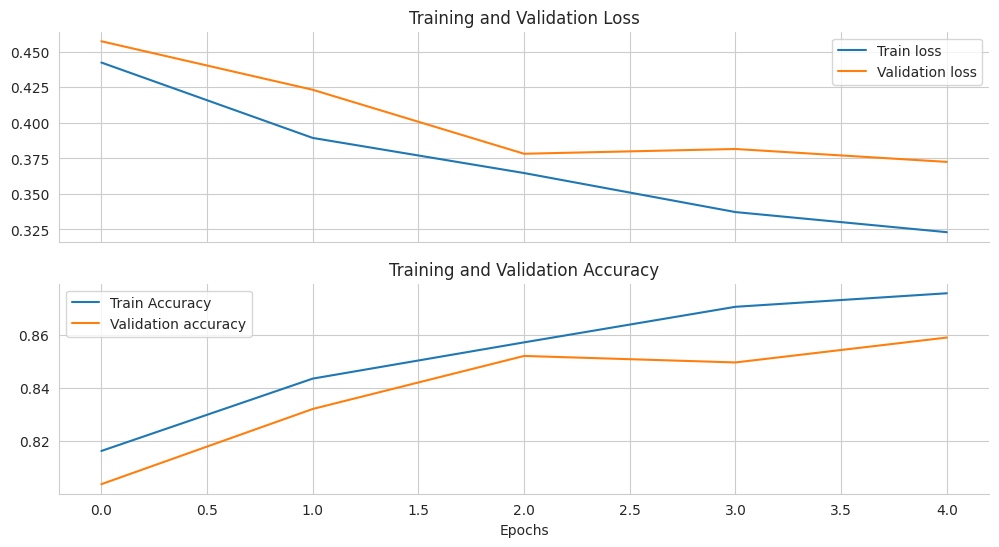

In [ ]:
sns.set_style("whitegrid")
fig, (ax1, ax2) = plt.subplots(2, 1, sharex='col', figsize=(12, 6))

ax1.plot(history_mejorado['loss'], label='Train loss')
ax1.plot(history_mejorado['val_loss'], label='Validation loss')
ax1.legend(loc='best')
ax1.set_title('Training and Validation Loss')
ax1.legend()

ax2.plot(history_mejorado['accuracy'], label='Train Accuracy')
ax2.plot(history_mejorado['val_accuracy'], label='Validation accuracy')
ax2.legend(loc='best')
ax2.set_title('Training and Validation Accuracy')

plt.xlabel('Epochs')
sns.despine()
plt.show()

In [ ]:
# Almacenamos nuestro modelo

directorio_modelo = '/content/CNN'

if not os.path.exists(directorio_modelo):
    os.makedirs(directorio_modelo)

model.save('/content/CNN/modelo.h5')

In [ ]:
######################################################################################################################################

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
from PIL import Image
from tensorflow.keras.models import load_model
import keras

# Cargar el modelo

In [ ]:
modelo = keras.models.load_model('/content/CNN/modelo.h5')

TypeError: Error when deserializing class 'InputLayer' using config={'batch_shape': [None, 512, 512, 3], 'dtype': 'float32', 'sparse': False, 'name': 'input_layer'}.

Exception encountered: Unrecognized keyword arguments: ['batch_shape']

In [ ]:
# Carpeta de las imágenes de prueba
directorio_pruebas = '/content/upch-intro-ml/test/test'

# Función para cargar y preprocesar una imagen
def cargar_y_preprocesar_imagen(ruta_imagen):
    imagen = cv2.imread(ruta_imagen)
    imagen = cv2.resize(imagen, (512, 512))
    imagen = imagen.astype('float32') / 255.0
    imagen = np.expand_dims(imagen, axis=-1)
    imagen = np.expand_dims(imagen, axis=0)

    return imagen

In [ ]:
# Context manager para suprimir la salida estándar
@contextmanager
def suppress_stdout():
    with open(os.devnull, "w") as devnull:
        old_stdout = sys.stdout
        sys.stdout = devnull
        try:
            yield
        finally:
            sys.stdout = old_stdout

In [ ]:
# Iteramos nuestro Data Frame de ejemplo

for i, fila in tqdm.tqdm(df_samples.iterrows(), desc="Procesando imágenes", unit=" imagen"):
    ruta_imagen = fila['ID']
    img_array = cargar_y_preprocesar_imagen(ruta_imagen)

    with suppress_stdout():
        prediccion = modelo.predict(img_array)

    if prediccion[0][0] >= 0.5:
        resultado = 1
    else:
        resultado = 0

    nombre_archivo_con_extension = os.path.basename(ruta_imagen)
    nombre_archivo, extension = os.path.splitext(nombre_archivo_con_extension)
    df_samples.at[i, 'ID'] = nombre_archivo
    df_samples.at[i, 'score'] = resultado

Procesando imágenes: 10538 imagen [20:47,  8.45 imagen/s]


In [ ]:
df_samples.to_csv('df_muestra.csv', index=False)

In [ ]:
#######################################################################################################################################